In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

from msfm.grid_pipeline import GridPipeline
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import files, scales
from msfm.utils.input_output import read_yaml

24-05-10 01:15:27   imports.py INF   Setting up healpy to run on 256 CPUs 
24-05-10 01:15:27   imports.py INF   Setting up healpy to run on 256 CPUs 


In [3]:
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v8/linear_bias_no_smoothing/tfrecords/grid/DESy3_grid_dmb_0001.tfrecord"

conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v8/linear_bias_no_smoothing.yaml"
conf = files.load_config(conf)
params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
filename_suffix = "_v8"

l_min = 30

In [4]:
# in degrees
x_deg = 10
y_deg = x_deg

# in pixels
x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

rot=(90, -30, 0)

# load example map 

24-05-10 01:15:28     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-05-10 01:15:28     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-05-10 01:15:29 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-05-10 01:15:29 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-05-10 01:15:29 grid_pipelin INF   Including noise_indices = [0, 1, 2] 
24-05-10 01:15:29 grid_pipelin INF   Interleaving with n_readers = 1 
24-05-10 01:15:30 grid_pipelin INF   Batching into 1 elements locally 
24-05-10 01:15:30 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, 

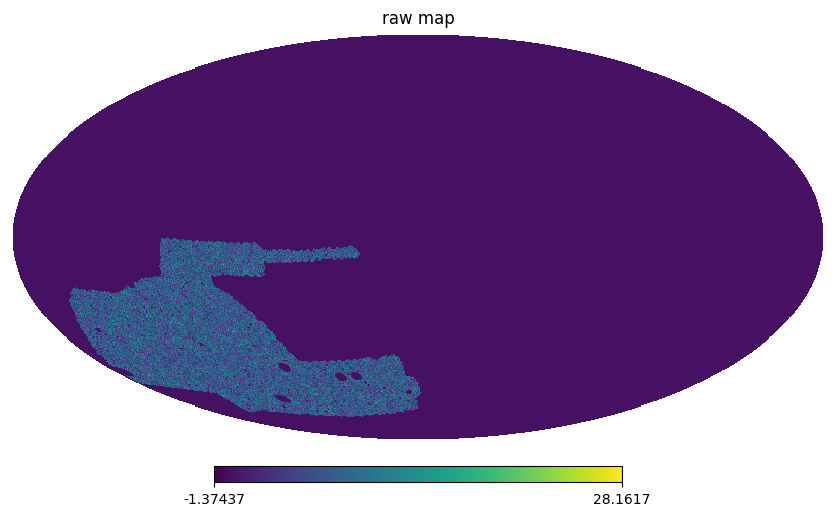

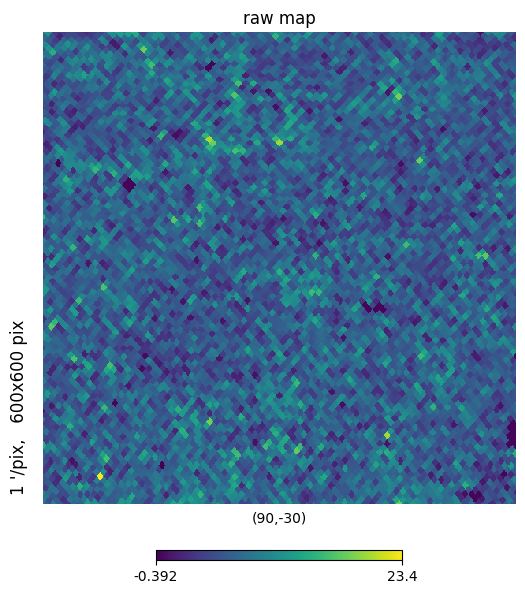

In [5]:
with_lensing = True
with_clustering = True

grid_pipe = GridPipeline(
    conf=conf,
    params=params,
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_padding=True,
    # apply_norm=False,
    apply_norm=True,
)

data_vec_pix = grid_pipe.data_vec_pix
n_side = 512
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal
n_noise = 3

grid_dset = grid_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    noise_indices=n_noise,
    local_batch_size=1,
    n_readers=1,
    n_prefetch=0,
)

for dv, cosmo, index in grid_dset.take(n_noise):
    pass

raw_map = np.zeros(n_pix)
raw_map[data_vec_pix] = dv[0,:,4]

hp.mollview(raw_map, title="raw map", nest=True)
hp.gnomview(raw_map, title="raw map", nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix)

# hard l_min cut

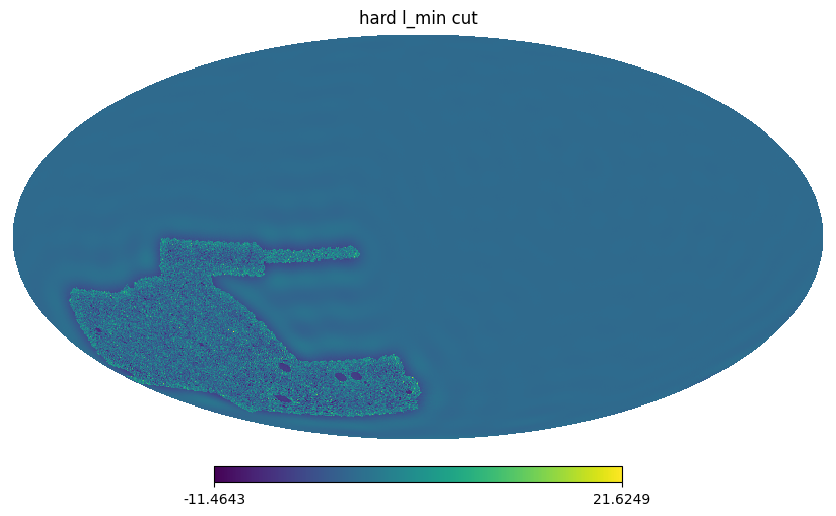

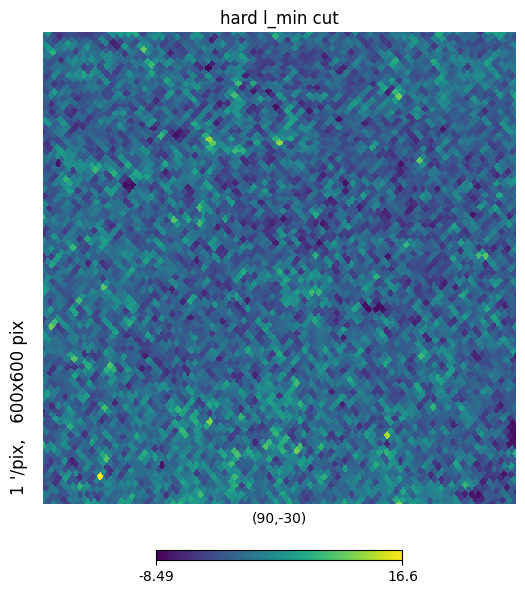

In [6]:
hard_map, _ = scales.map_to_smoothed_map(raw_map, n_side, l_min, theta_fwhm=0.0, nest=True, soft_l_min_cut=False)
hp.mollview(hard_map, title="hard l_min cut", nest=True)
hp.gnomview(hard_map, title="hard l_min cut", nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix)

# soft l_min cut

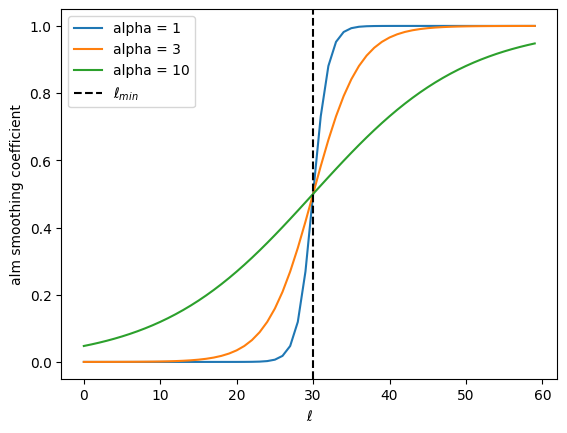

In [7]:
# ell = np.arange(3 * n_side - 1)
ell = np.arange(60)
sigmoid = lambda x, delta, alpha: 1 / (1 + np.exp((delta - x) / alpha))

fig, ax = plt.subplots()

for alpha in [1, 3, 10]:
    ax.plot(ell, sigmoid(ell, l_min, alpha), label=f"alpha = {alpha}")
    
ax.axvline(l_min, color="k", linestyle="--", label=r"$\ell_{min}$")
ax.set(xlabel=r"$\ell$", ylabel="alm smoothing coefficient")
ax.legend()

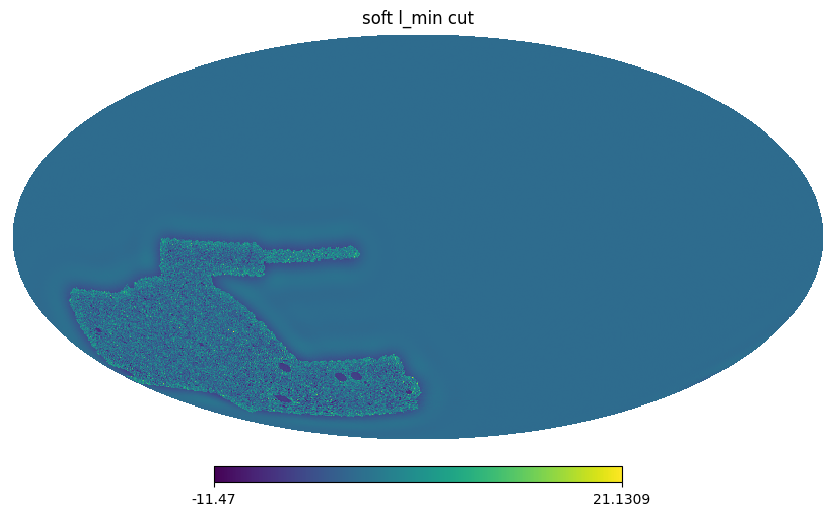

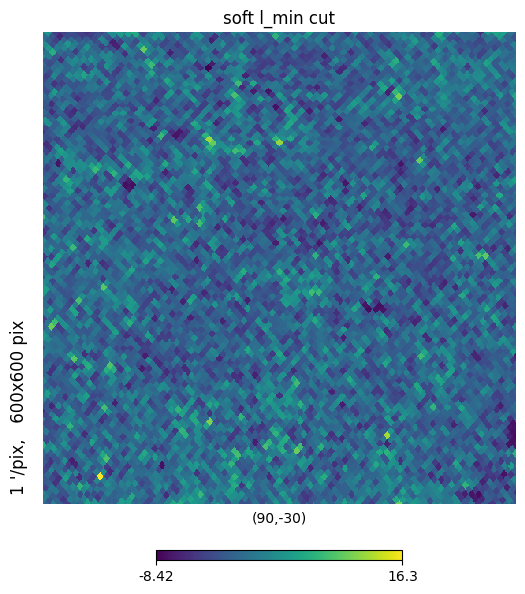

In [8]:
soft_map, _ = scales.map_to_smoothed_map(raw_map, n_side, l_min, theta_fwhm=0.0, nest=True, soft_l_min_cut=True)
hp.mollview(soft_map, title="soft l_min cut", nest=True)
hp.gnomview(soft_map, title="soft l_min cut", nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix)

# Gaussian smoothing

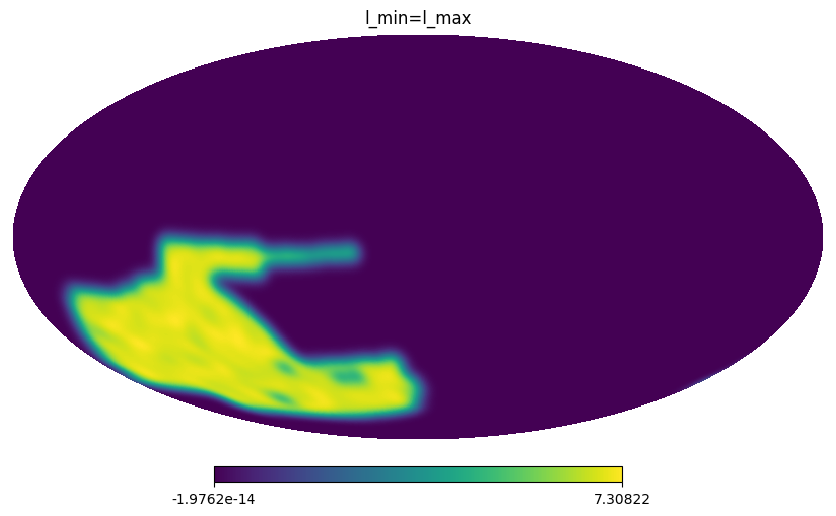

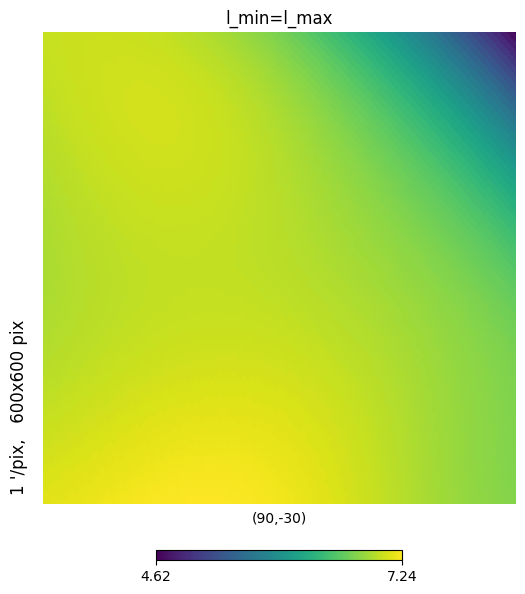

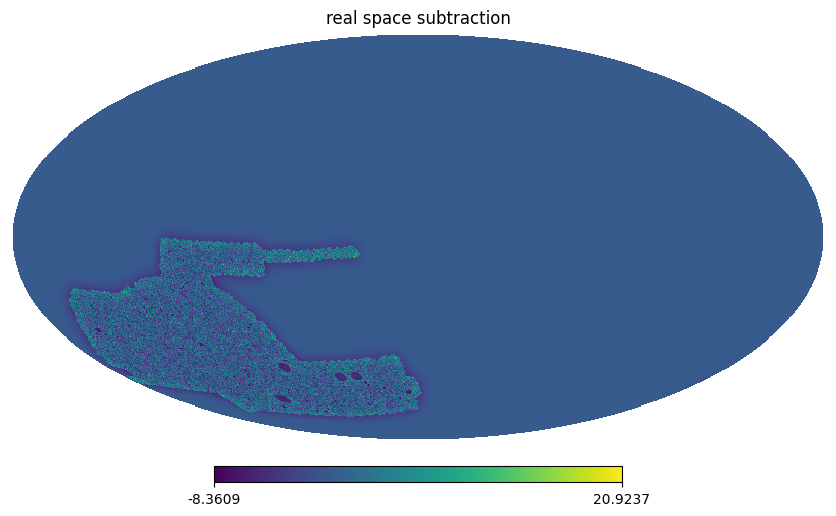

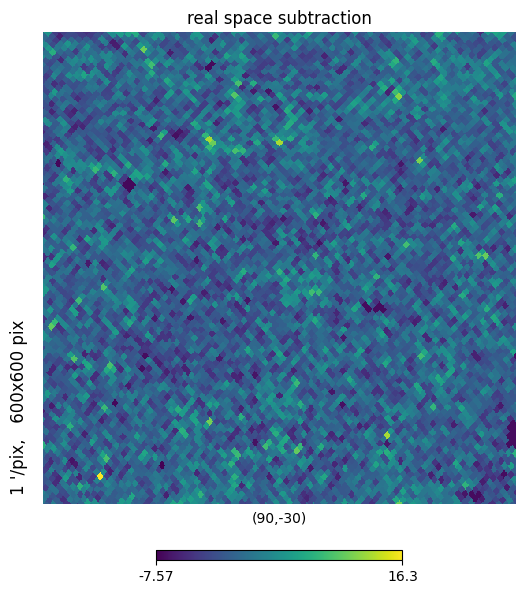

In [9]:
# very_smooth_map = hp.smoothing(raw_map, fwhm=scales.arcmin_to_rad(100), use_pixel_weights=True, nest=True)
fwhm = scales.ell_to_angle(l_min, arcmin=False)
l_min_map = hp.smoothing(raw_map, fwhm=fwhm, use_pixel_weights=True, nest=True)
hp.mollview(l_min_map, title="l_min=l_max", nest=True)
hp.gnomview(l_min_map, title="l_min=l_max", nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix)

real_space_map = raw_map - l_min_map
hp.mollview(real_space_map, title="real space subtraction", nest=True)
hp.gnomview(real_space_map, title="real space subtraction", nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix)

In [10]:
raw_cls = hp.anafast(raw_map)
l_min_cls = hp.anafast(l_min_map)
real_space_cls = hp.anafast(real_space_map)

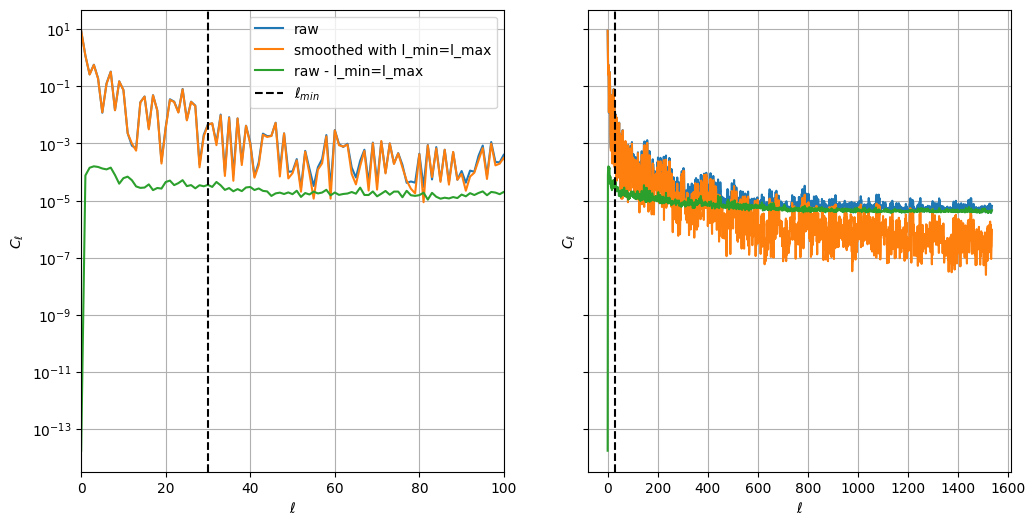

In [11]:
fig, ax = plt.subplots(figsize=(12,6), ncols=2, sharex=False, sharey=True)

ax[0].plot(raw_cls, label="raw")
ax[0].plot(l_min_cls, label="smoothed with l_min=l_max")
ax[0].plot(real_space_cls, label="raw - l_min=l_max")
ax[0].axvline(l_min, color="k", linestyle="--", label=r"$\ell_{min}$")

ax[0].set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", xlim=(0,100))
ax[0].grid(True)
ax[0].legend()

ax[1].plot(raw_cls, label="raw")
ax[1].plot(l_min_cls, label="smoothed with l_min=l_max")
ax[1].plot(real_space_cls, label="raw - l_min=l_max")
ax[1].axvline(l_min, color="k", linestyle="--", label=r"$\ell_{min}$")

ax[1].set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log")
ax[1].grid(True)

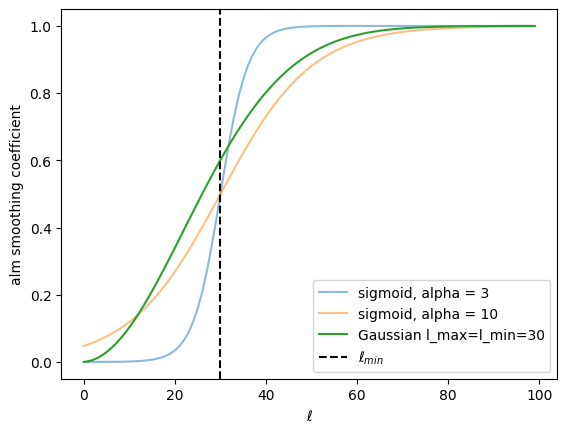

In [12]:
# ell = np.arange(3 * n_side - 1)
ell = np.arange(100)

sigmoid = lambda l, delta, alpha: 1 / (1 + np.exp((delta - l) / alpha))

gauss = lambda l, sigma: 1 - np.exp(-0.5 * l * (l + 1) * sigma**2)
sigma = fwhm / (2*np.sqrt(2*np.log(2)))

fig, ax = plt.subplots()

for alpha in [3, 10]:
    ax.plot(ell, sigmoid(ell, l_min, alpha), label=f"sigmoid, alpha = {alpha}", alpha=0.5)
    
ax.plot(ell, gauss(ell, sigma), label=f"Gaussian l_max=l_min={l_min}")
    
ax.axvline(l_min, color="k", linestyle="--", label=r"$\ell_{min}$")
ax.set(xlabel=r"$\ell$", ylabel="alm smoothing coefficient")
ax.legend()

# differences

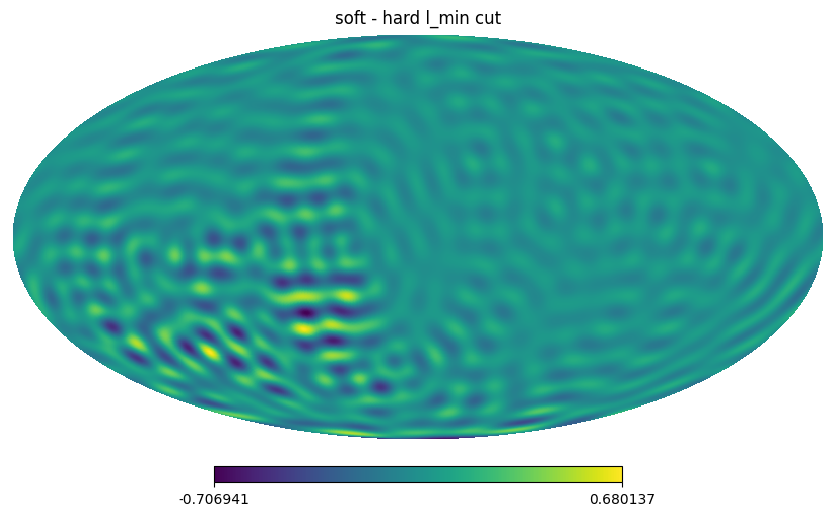

In [13]:
hp.mollview(soft_map - hard_map, title="soft - hard l_min cut", nest=True)

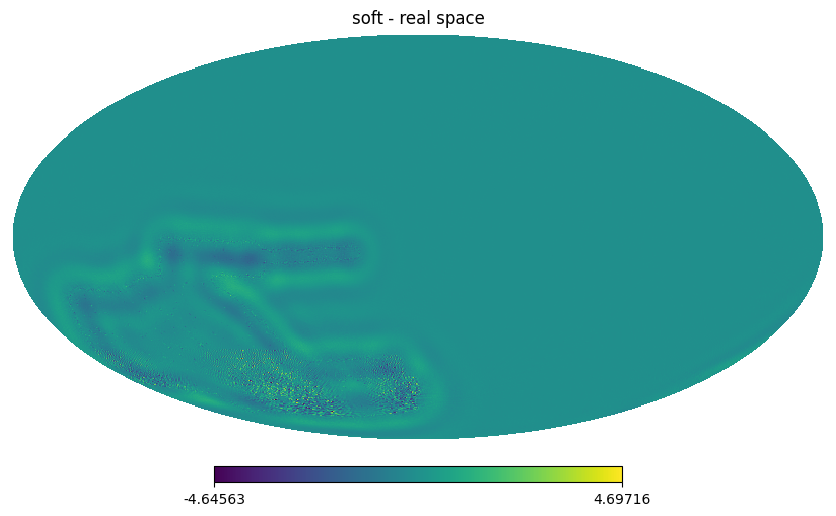

In [14]:
hp.mollview(soft_map - real_space_map, title="soft - real space", nest=True)